In [1]:
import numpy as np
import os
import random
import torch

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from Callbacks import EarlyStopping
from TransferLearningModel import TransferLearningModel
from utils import DicomFineDataset3D

In [2]:
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten/nodule"
# BASE_DIR = "C:/Users/domin/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 32
image_size = 80 #best yet 80 with 87%
classes = ["A", "B", "E", "G"]
train_ratio = 0.6

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

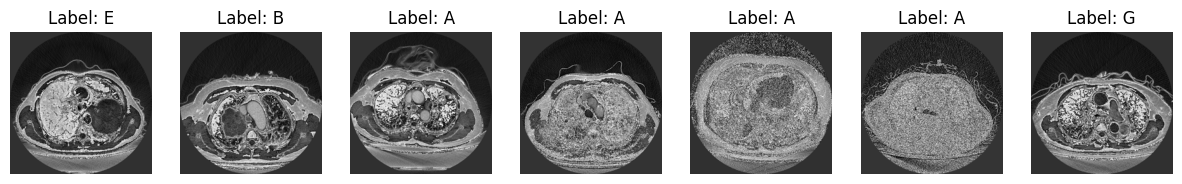

In [3]:
dataset = DicomFineDataset3D(root_dir=BASE_DIR, classes=classes)
# dataset = DicomCoarseDataset3D(root_dir=BASE_DIR, num_images_per_class=100, classes=classes, scenario=1)
dataset.visualize_volumes(num_volumes=7)

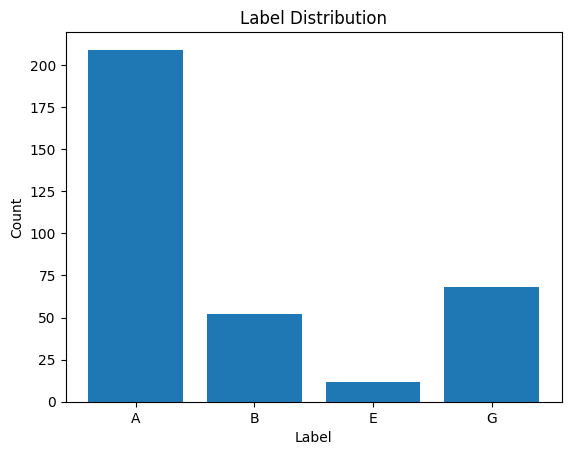

In [4]:
dataset.display_label_distribution()

In [5]:
train_size = int(train_ratio * len(dataset))
val_size = int(((1-train_ratio)/2) * len(dataset)) 
test_size = len(dataset) - train_size - val_size

print(f"Train size: {train_size} --- Validation size: {val_size} --- Test size: {test_size}")

Train size: 204 --- Validation size: 68 --- Test size: 69


In [6]:
print("Processing model: 3D-CNN")
model = TransferLearningModel(classes, "3dcnn", data_augmentation=False, fine=True)

# Ensure transforms are correctly applied based on model requirements
model.train_transforms, model.test_transforms = model.get_transforms()
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply specific transforms to each subset
train_dataset.dataset.transform = model.train_transforms
val_dataset.dataset.transform = model.test_transforms
test_dataset.dataset.transform = model.test_transforms

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize early stopping
early_stopping = EarlyStopping(patience=10)

# Train the current model
model.train(train_loader, val_loader, early_stopping, epochs=50)

Processing model: 3D-CNN
Epoch 1/50 ----- Loss: 0.8416, Accuracy: 70.10% ----- Validation Loss: 11.7694, Validation Accuracy: 19.12%
Epoch 2/50 ----- Loss: 0.5769, Accuracy: 81.86% ----- Validation Loss: 2.8145, Validation Accuracy: 30.88%
Epoch 3/50 ----- Loss: 0.6336, Accuracy: 82.35% ----- Validation Loss: 2.2548, Validation Accuracy: 41.18%
Epoch 4/50 ----- Loss: 0.5006, Accuracy: 83.33% ----- Validation Loss: 1.4736, Validation Accuracy: 57.35%
Epoch 5/50 ----- Loss: 0.4241, Accuracy: 89.22% ----- Validation Loss: 0.8276, Validation Accuracy: 75.00%
Epoch 6/50 ----- Loss: 0.3943, Accuracy: 88.73% ----- Validation Loss: 0.5472, Validation Accuracy: 83.82%
Epoch 7/50 ----- Loss: 0.3356, Accuracy: 92.65% ----- Validation Loss: 0.4304, Validation Accuracy: 88.24%
Epoch 8/50 ----- Loss: 0.2832, Accuracy: 93.63% ----- Validation Loss: 0.3680, Validation Accuracy: 89.71%
Epoch 9/50 ----- Loss: 0.2784, Accuracy: 92.65% ----- Validation Loss: 0.3299, Validation Accuracy: 89.71%
Epoch 10/50

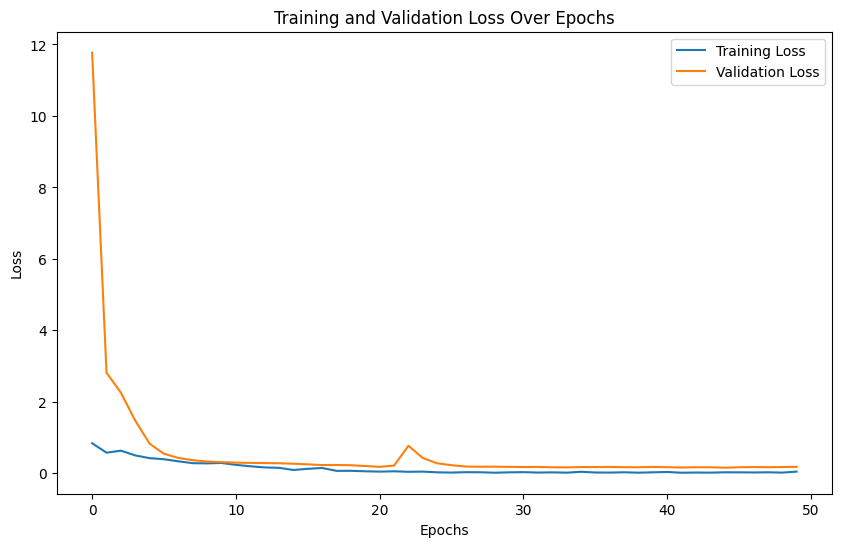

In [7]:
model.plot_loss()

0.15740819888956406
Evaluation Accuracy on unseen data: 89.85507246376811


<Figure size 1000x800 with 0 Axes>

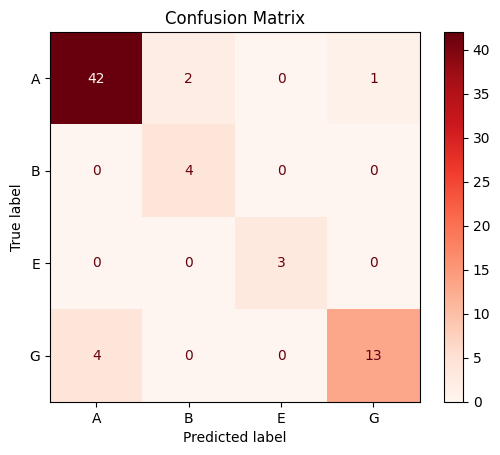

In [9]:
checkpoint = torch.load(f"weights/fine/{model.model_name}.pt", weights_only=False)
model.model.load_state_dict(checkpoint['model_state_dict'])
loss = checkpoint["loss"]
print(loss)
model.evaluate(test_loader)